In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from dino_paint_utils import selfpredict_dino_forest
from FoodSeg103_data_handler import *
from scribbles_creator import create_even_scribbles
from convpaint_helpers import selfpred_convpaint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create scribbles

Load the images and ground truths as lists/batches

In [ ]:
img_nums = [n for n in range(0, 4900, 250)] #2750 #1234 #2314
imgs, gts = load_food_batch(nums)
num_imgs = len(imgs)
print(f"Total images: {num_imgs}")

Check and filter for resolution

In [ ]:
resol = {im_num: np.prod(im.shape) for im_num, im in imgs.items()}
# Check for images with resolution over a certain threshold
thresh = 600_000
print("Resolutions:")
for im_num, r in resol.items(): print(f"{im_num:4d}: {r:9,d} pixels{' (!)' if r > thresh else ''}")

In [ ]:
# Filter out those images
imgs, gts = {im_num: im for im_num, im in imgs.items() if resol[im_num] < thresh}, {im_num: gt for im_num, gt in gts.items() if resol[im_num] < thresh}
num_imgs = len(imgs)
print(f"Images with resolution under {thresh:,d}: {num_imgs}")
resol_new = {im_num: np.prod(im.shape) for im_num, im in imgs.items()}
for im_num, r in resol_new.items(): print(f"{im_num:4d}: {r:7,d} pixels")

Define scribbles parameters

In [24]:
bin=0.125
suff="w3" #standing for width 3
sq_scaling=100
scribble_width=3
scribbles_seed = 1

img, ground_truth = load_food_batch(img_nums)
folder_path = "./FoodSeg103_results/data/run01"

Loop and create scribbles

In [27]:
scribbles, perc_labelled = create_food_scribble(ground_truth, folder_path, img_num, bin=bin, sq_scaling=sq_scaling, mode="all", save_res=True, suff=suff, show_res=True, image=img, print_steps=False, scribble_width=3)

Adjusting square size and range to 22 (9, 88)
Adjusting square size and range to 11 (5, 88)
Adjusting square size and range to 22 (9, 88)
Adjusting square size and range to 11 (5, 88)
Adjusting square size and range to 5 (2, 88)
Adjusting square size and range to 22 (11, 88)
Adjusting square size and range to 22 (11, 88)
Adjusting square size and range to 11 (5, 88)
Adjusting square size and range to 22 (6, 88)
Adjusting square size and range to 11 (5, 88)
Adjusting square size and range to 22 (6, 88)
Adjusting square size and range to 11 (5, 88)
Adjusting square size and range to 22 (11, 88)
Annotation percentage: 0.44%


In [49]:
pred_ila = pred_food_ilastik(img, folder_path, img_num, mode="all", bin=bin, suff=suff, save_res=False, show_res=True, ground_truth=ground_truth)
# pred_ila = pred_food_ilastik_simple(img, scribbles)
acc_ila = np.sum(ground_truth == pred_ila) / np.prod(ground_truth.shape)
print(f"Accuracy Ilastik: {np.round(acc_ila*100, 2)}%")

Accuracy Ilastik: 63.87%


In [50]:
pred_conv = pred_food_convpaint(img, folder_path, img_num, mode="all", bin=bin, suff=suff, layer_list=layers, scalings=scalings, model="vgg16", random_state=convpaint_seed,
                                save_res=False, show_res=True, ground_truth=ground_truth)
# pred_conv = selfpred_convpaint(img, scribbles, random_state=convpaint_seed)
acc_conv = np.sum(ground_truth == pred_conv) / np.prod(ground_truth.shape)
print(f"Accuracy Convpaint: {np.round(acc_conv*100, 2)}%")

Accuracy Convpaint: 73.44%


In [42]:
results_dino = selfpredict_dino_forest(img, scribbles, ground_truth=ground_truth,
                                    dinov2_model='s', dinov2_layers=(), dinov2_scales=(), upscale_order=1, pad_mode='reflect', extra_pads=(),
                                    vgg16_layers=None, vgg16_scales=(), append_image_as_feature=False, show_napari=False)
pred_dino, image_dino, labels_dino, feature_space_dino, acc_dino = results_dino
print(f"Accuracy DINOv2: {np.round(acc_dino*100, 2)}%")

C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Accuracy DINOv2: 86.81%


Show results

In [44]:
v = napari.Viewer()
v.add_image(img)
v.add_labels(ground_truth)
v.add_labels(scribbles)
v.add_labels(pred_dino)
v.add_labels(pred_conv)
v.add_labels(pred_ila)

<Labels layer 'pred_ila' at 0x1e9177f3e20>

## Loop over multiple images

Load the images and ground truths as lists/batches

In [140]:
nums = [n for n in range(0, 4900, 250)]
imgs, gts = load_food_batch(nums)
num_imgs = len(imgs)
print(f"Total images: {num_imgs}")

Total images: 20


Check and filter for resolution

In [141]:
resol = [np.prod(im.shape) for im in imgs]
print("Resolutions:", pd.DataFrame(resol).describe(), "", sep="\n")

# Filter for images with resolution under a certain threshold (for computational reasons)
thresh = 600_000
imgs, gts = [im for i, im in enumerate(imgs) if resol[i] < thresh], [gt for i, gt in enumerate(gts) if resol[i] < thresh]
num_imgs = len(imgs)
print(f"Images with resolution under {thresh:,d}: {num_imgs}")

Resolutions:
                  0
count  2.000000e+01
mean   9.860949e+05
std    1.997764e+06
min    1.966080e+05
25%    4.884690e+05
50%    5.898240e+05
75%    6.236160e+05
max    9.437184e+06

Images with resolution under 600,000: 15


In [142]:
scribbles_seed = 1
convpaint_seed = 123
convpaint_layers = [0]
convpaint_scalings = [1,2]
repeat_run = False
if not repeat_run:
    res_df = pd.DataFrame(columns=["img_num", 'perc. labelled', "acc_convpaint", "acc_ilastik", "acc_dino"])
    scribbles_list = []
for i in range(num_imgs):
    np.random.seed(scribbles_seed)
    img_num = nums[i]
    print(f"IMG {img_num}")
    # Create scribbles and note its percentage
    img, ground_truth = imgs[i], gts[i]
    if not repeat_run:
        scribbles = create_even_scribbles(ground_truth, max_perc=0.5, sq_scaling=100, mode="all", print_steps=False, scribbles_width=3)
        scribbles_list.append(scribbles)
        perc_labelled = np.sum(scribbles>0) / np.prod(ground_truth.shape) * 100
    else:
        scribbles = scribbles_list[i]
    # Predict with Convpaint and note its accuracy
    pred_conv = selfpred_convpaint(img, scribbles, random_state=convpaint_seed)#, layer_list=convpaint_layers, scalings=convpaint_scalings)
    acc_conv = np.sum(ground_truth == pred_conv) / np.prod(ground_truth.shape)
    if not repeat_run:
        new_row = pd.DataFrame({"img_num": img_num, 'perc. labelled': perc_labelled, "acc_convpaint": acc_conv, "acc_ilastik": np.nan, "acc_dino": np.nan}, index = (0,))
        res_df = pd.concat([res_df, new_row], ignore_index=True)
    else:
        res_df.loc[res_df["img_num"] == img_num, "acc_convpaint"] = acc_conv
    # Predict with Ilastik and note its accuracy
    pred_ila = pred_food_ilastik(img, scribbles)
    acc_ila = np.sum(ground_truth == pred_ila) / np.prod(ground_truth.shape)
    res_df.loc[res_df["img_num"] == img_num, "acc_ilastik"] = acc_ila
    # Predict with DINOv2 from dino_paint
    results_dino = selfpredict_dino_forest(img, scribbles, ground_truth=ground_truth,
                                        dinov2_model='s', dinov2_layers=(), dinov2_scales=(), upscale_order=0, pad_mode='reflect', extra_pads=(),
                                        vgg16_layers=None, vgg16_scales=(), append_image_as_feature=False, show_napari=False)
    pred_dino, image_dino, labels_dino, feature_space_dino, acc_dino = results_dino
    res_df.loc[res_df["img_num"] == img_num, "acc_dino"] = acc_dino
    print("\n")

IMG 0


C:\Users\roman\AppData\Local\Temp\ipykernel_14916\1171817575.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, new_row], ignore_index=True)




IMG 250
Adjusting square size and range to 16 (8, 66)
Adjusting square size and range to 16 (8, 66)
Adjusting square size and range to 16 (8, 66)
Adjusting square size and range to 16 (8, 66)


IMG 500
Adjusting square size and range to 22 (11, 88)


IMG 750
Adjusting square size and range to 12 (6, 50)
Adjusting square size and range to 12 (6, 50)
Adjusting square size and range to 12 (6, 50)
Adjusting square size and range to 12 (6, 50)
Adjusting square size and range to 6 (3, 50)


IMG 1000
Adjusting square size and range to 18 (7, 72)
Adjusting square size and range to 9 (4, 72)
Adjusting square size and range to 18 (7, 72)
Adjusting square size and range to 9 (4, 72)
Adjusting square size and range to 18 (9, 72)
Adjusting square size and range to 18 (9, 72)
Adjusting square size and range to 9 (4, 72)
Adjusting line range to (5, 144)
Adjusting line range to (2, 288)
Adjusting line range to (1, 576)
Adjusting distance to edge to 3
Adjusting distance to edge to 4
Adjusting distanc

In [143]:
print(f"Accuracy Convpaint: {res_df['acc_convpaint'].mean():7.4f} (+/- {res_df['acc_convpaint'].std():.4f})")
print(f"Accuracy Ilastik: {res_df['acc_ilastik'].mean():9.4f} (+/- {res_df['acc_ilastik'].std():.4f})")
print(f"Accuracy DINOv2: {res_df['acc_dino'].mean():10.4f} (+/- {res_df['acc_dino'].std():.4f})")

res_df["diff"] = res_df["acc_convpaint"] - res_df["acc_ilastik"]
res_df = res_df.sort_values("diff", ascending=False)
print("", "Accuracy differences (Convpaint - Ilastik):", res_df["diff"].describe(), "", sep="\n")

res_df

Accuracy Convpaint:  0.7954 (+/- 0.0778)
Accuracy Ilastik:    0.7459 (+/- 0.1002)
Accuracy DINOv2:     0.8834 (+/- 0.0563)

Accuracy differences (Convpaint - Ilastik):
count    15.000000
mean      0.049539
std       0.047917
min      -0.012049
25%       0.015133
50%       0.042946
75%       0.087148
max       0.148122
Name: diff, dtype: float64



,img_num,perc. labelled,acc_convpaint,acc_ilastik,acc_dino,diff
14,3500,1.677778,0.693856,0.545733,0.825267,0.148122
7,1750,1.727295,0.733749,0.624191,0.858749,0.109558
2,500,1.718140,0.849884,0.756897,0.805405,0.092987
12,3000,1.641846,0.687342,0.597300,0.874837,0.090042
0,0,1.808675,0.922531,0.838277,0.905116,0.084254
13,3250,1.678467,0.881714,0.824061,0.906809,0.057653
11,2750,1.648458,0.832779,0.783117,0.933487,0.049662
10,2500,1.796301,0.700075,0.657129,0.932824,0.042946
5,1250,1.740011,0.875473,0.835093,0.938451,0.040380
4,1000,1.557684,0.786862,0.758185,0.937498,0.028677


## Plot

In [93]:
from matplotlib import pyplot as plt
import seaborn as sns

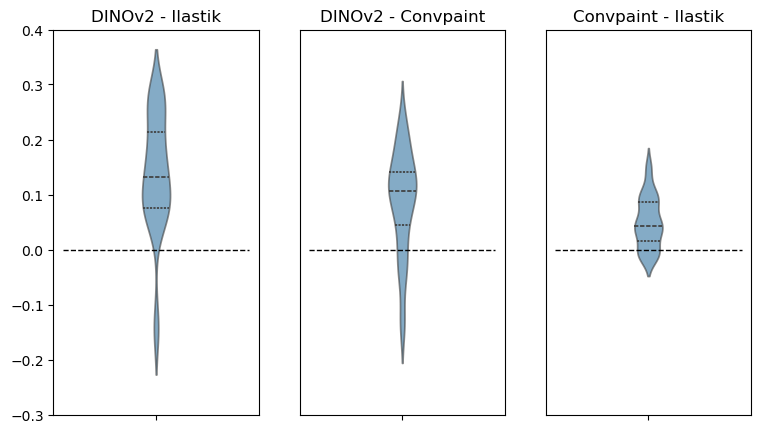

In [176]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(9, 5)
violin_args = {"alpha": 0.6, "inner": "quart", "bw_adjust": 0.65, "width": 0.3}
# fig.tight_layout()
# sns.boxplot(res_df["diff"], orient="v", color="skyblue", width=0.3, linewidth=1.5, fliersize=2.5, whis=1.5)

curr_ax = ax[2]
curr_ax.set_title("Convpaint - Ilastik")
sns.violinplot(res_df["diff"], ax=curr_ax, **violin_args)
curr_ax.set_ylabel("Accuracy diff.")

curr_ax = ax[0]
curr_ax.set_title("DINOv2 - Ilastik")
sns.violinplot(res_df["acc_dino"] - res_df['acc_ilastik'], ax=curr_ax, **violin_args)

curr_ax = ax[1]
curr_ax.set_title("DINOv2 - Convpaint")
sns.violinplot(res_df["acc_dino"] - res_df['acc_convpaint'], ax=curr_ax, **violin_args)

for a in ax:
    a.set_ylim(-0.3, 0.4)
    a.hlines(0, -1, 1, color="black", linewidth=1, linestyles='dashed')

for a in ax[1:]:
    a.set_ylabel("")
    a.set_yticks([])

plt.show()

Show the last image with ground truth, scribbles and prediction

In [126]:
v = napari.Viewer()
v.add_image(img)
v.add_labels(ground_truth)
v.add_labels(scribbles)
v.add_labels(pred_conv)
v.add_labels(pred_ila)
v.add_labels(pred_dino)


<Labels layer 'pred_dino' at 0x1ba0967cd90>

In [135]:
v = napari.Viewer()
v.add_labels(scribbles)
v.add_labels(scribbles_list[11])

<Labels layer 'Labels' at 0x1ba444880d0>

## Properties of the dataset

In [ ]:
# Shape of the dataset
food_data_shape = (4983, 2)

#Label dictionary
id2label = {1: 'background',
            2: 'candy',
            3: 'egg tart',
            4: 'french fries',
            5: 'chocolate',
            6: 'biscuit',
            7: 'popcorn',
            8: 'pudding',
            9: 'ice cream',
            10: 'cheese butter',
            11: 'cake',
            12: 'wine',
            13: 'milkshake',
            14: 'coffee',
            15: 'juice',
            16: 'milk',
            17: 'tea',
            18: 'almond',
            19: 'red beans',
            20: 'cashew',
            21: 'dried cranberries',
            22: 'soy',
            23: 'walnut',
            24: 'peanut',
            25: 'egg',
            26: 'apple',
            27: 'date',
            28: 'apricot',
            29: 'avocado',
            30: 'banana',
            31: 'strawberry',
            32: 'cherry',
            33: 'blueberry',
            34: 'raspberry',
            35: 'mango',
            36: 'olives',
            37: 'peach',
            38: 'lemon',
            39: 'pear',
            40: 'fig',
            41: 'pineapple',
            42: 'grape',
            43: 'kiwi',
            44: 'melon',
            45: 'orange',
            46: 'watermelon',
            47: 'steak',
            48: 'pork',
            49: 'chicken duck',
            50: 'sausage',
            51: 'fried meat',
            52: 'lamb',
            53: 'sauce',
            54: 'crab',
            55: 'fish',
            56: 'shellfish',
            57: 'shrimp',
            58: 'soup',
            59: 'bread',
            60: 'corn',
            61: 'hamburg',
            62: 'pizza',
            63: 'hanamaki baozi',
            64: 'wonton dumplings',
            65: 'pasta',
            66: 'noodles',
            67: 'rice',
            68: 'pie',
            69: 'tofu',
            70: 'eggplant',
            71: 'potato',
            72: 'garlic',
            73: 'cauliflower',
            74: 'tomato',
            75: 'kelp',
            76: 'seaweed',
            77: 'spring onion',
            78: 'rape',
            79: 'ginger',
            80: 'okra',
            81: 'lettuce',
            82: 'pumpkin',
            83: 'cucumber',
            84: 'white radish',
            85: 'carrot',
            86: 'asparagus',
            87: 'bamboo shoots',
            88: 'broccoli',
            89: 'celery stick',
            90: 'cilantro mint',
            91: 'snow peas',
            92: 'cabbage',
            93: 'bean sprouts',
            94: 'onion',
            95: 'pepper',
            96: 'green beans',
            97: 'French beans',
            98: 'king oyster mushroom',
            99: 'shiitake',
            100: 'enoki mushroom',
            101: 'oyster mushroom',
            102: 'white button mushroom',
            103: 'salad',
            104: 'other ingredients'}